In [11]:
#The following 5 cells are setup for essential variables that will be used in the model creation
import numpy as np
from sklearn import metrics
import seaborn as sns

sources = [{'name': 'unicef_sowc',
            'url': 'https://data.unicef.org/wp-content/uploads/2023/04/SOWC-2023-Statistical-tables-All-EN.xlsx'}, 
           {'name': 'undp_hdr',
            'url': 'https://hdr.undp.org/sites/default/files/2021-22_HDR/HDR21-22_Composite_indices_complete_time_series.csv'},
           {'name': 'worldbank_wbi',
            'url': 'https://datacatalogfiles.worldbank.org/ddh-published/0037712/DR0090755/CLASS.xlsx'},
           {'name': 'fundforpeace_fsi',
            'url': 'https://fragilestatesindex.org/wp-content/uploads/2023/06/FSI-2023-DOWNLOAD.xlsx'}]
import pandas as pd
#setting up relevant dataframes:
df_indicators = pd.read_csv('country_indicators.csv') #indicators
df_preds = pd.read_csv('test_predictions.csv') #predictions
df = df_preds.merge(df_indicators, left_on='iso3', right_on='iso3', how='inner') #merging

In [12]:
# Getting probability prediction errors
df_preds['transformer_probability_prediction_error'] = np.abs(df_preds['y_true_transformer'].astype(float) - df_preds['y_pred_proba_transformer'])
df_preds[['y_true_transformer','y_pred_proba_transformer','transformer_probability_prediction_error']]

,y_true_transformer,y_pred_proba_transformer,transformer_probability_prediction_error
0,False,0.183897,0.183897
1,False,0.267831,0.267831
2,False,0.482585,0.482585
3,False,0.187792,0.187792
4,True,0.539319,0.460681
...,...,...,...
359,False,0.182196,0.182196
360,False,0.203236,0.203236
361,False,0.527107,0.527107
362,False,0.555677,0.555677


In [13]:
#More probability prediction error
df['error_transformer'] = np.abs(df.y_true_transformer-df.y_pred_proba_transformer)
df['error_ffnn'] = np.abs(df.y_true_ffnn-df.y_pred_proba_ffnn)
df['error_xgboost'] = np.abs(df.y_true_xgboost-df.y_pred_proba_xgboost)

In [14]:
# Prediction Classification "Correctness"

threshold = 0.5 # using default classification threshold

# using transformer for this example demonstration, as opposed to
# df_preds.y_true_ffnn and df_preds.y_pred_proba_ffnn>threshold
# df_preds.y_true_xgboost and df_preds.y_pred_proba_xgboost>threshold
df_preds['transformer_classifcation_performance_outcome'] = None

tmp = df_preds['transformer_classifcation_performance_outcome'].copy()
TP_pos_pred_correct = df_preds.y_true_transformer & (df_preds.y_pred_proba_transformer>threshold)
tmp[TP_pos_pred_correct] = "correctly predicted escalation"
TN_neg_pred_correct = (~df_preds.y_true_transformer) & (df_preds.y_pred_proba_transformer<=threshold)
tmp[TN_neg_pred_correct] = "correctly predicted no escalation"
FP_pos_pred_wrong = (~df_preds.y_true_transformer) & (df_preds.y_pred_proba_transformer>threshold)
tmp[FP_pos_pred_wrong] = "wrongly predicted escalation"
FN_neg_pred_wrong = df_preds.y_true_transformer & (df_preds.y_pred_proba_transformer<=threshold)
tmp[FN_neg_pred_wrong] = "wrongly predicted no escalation"

df_preds['transformer_classifcation_performance_outcome'] = tmp
df_preds[['y_true_transformer','y_pred_transformer','transformer_classifcation_performance_outcome']][30:50]

,y_true_transformer,y_pred_transformer,transformer_classifcation_performance_outcome
30,True,True,correctly predicted escalation
31,False,True,wrongly predicted escalation
32,False,True,wrongly predicted escalation
33,False,True,wrongly predicted escalation
34,False,False,correctly predicted no escalation
35,False,True,wrongly predicted escalation
36,False,False,correctly predicted no escalation
37,False,False,correctly predicted no escalation
38,False,True,wrongly predicted escalation
39,False,True,wrongly predicted escalation


In [15]:
#CODE FROM PROJECT NOTEBOOK THAT CREATES INDICATOR VARIABLES:

# make df of column names and their dtypes
df_cols = pd.DataFrame(df.dtypes, columns=('coldtype',)).reset_index().rename(columns={'index': 'colname'})
df_cols['coldtype'] = df_cols['coldtype'].astype('string')
# adjusting a potentially useful variable that might be considered label
df['fsi_rank'] = df['fsi_rank'].astype('string').str.replace(r'\D', '', regex=True).replace('', pd.NA)
# get list of numeric variables
num_vars = df_cols.query("coldtype=='float64'")['colname'].values
# these could be useful; but, I'm ignoring them for now to keep the demonstration simpler...

import itertools

# Indicator variables are often called "one hot" encodings
def one_hot(df, cols):
    """ One-hot encode given `cols` and add as new columns
        to `df`
        
        Returns tuple of `df` with new columns and list of
        new column names.
    """
    new_cols = list()
    new_col_names = list()
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each)
        new_cols.append(dummies)
        new_col_names.append(dummies.columns.values)

    df = pd.concat([df]+new_cols, axis=1)
    new_col_names = list(itertools.chain.from_iterable(new_col_names))
    return df, new_col_names

# categorical variables we will turn into indicator ("one hot") variables
cat_vars = ['fsi_category', 'hdr_hdicode', 'hdr_region',
            'wbi_income_group', 'wbi_lending_category',
            'wbi_other_(emu_or_hipc)']
# Prof. Schwartz'z Note: 
# I'm not sure if there are other categorical variables in this data that could also be transformed
# These are just the ones Evan initially used as examples as he described the objectives of the project

# get one hot encodings
df_oh, oh_cols = one_hot(df, cat_vars)
df_oh = df_oh.drop(columns=cat_vars)

df_oh[['error_transformer','error_ffnn','error_xgboost'] + oh_cols]

,error_transformer,error_ffnn,error_xgboost,fsi_category_Alert,fsi_category_Stable,fsi_category_Sustainable,fsi_category_Warning,hdr_hdicode_High,hdr_hdicode_Low,hdr_hdicode_Medium,...,hdr_region_SSA,wbi_income_group_High income,wbi_income_group_Low income,wbi_income_group_Lower middle income,wbi_income_group_Upper middle income,wbi_lending_category_Blend,wbi_lending_category_IBRD,wbi_lending_category_IDA,wbi_other_(emu_or_hipc)_EMU,wbi_other_(emu_or_hipc)_HIPC
0,0.183897,0.409958,0.066500,0,0,0,1,1,0,0,...,0,0,0,0,1,1,0,0,0,0
1,0.267831,0.406696,0.099643,0,0,0,1,1,0,0,...,0,0,0,0,1,1,0,0,0,0
2,0.482585,0.545236,0.295914,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,1
3,0.187792,0.534560,0.361556,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,1
4,0.460681,0.461417,0.608380,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,0.182196,0.291874,0.079453,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
360,0.203236,0.300321,0.060189,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
361,0.527107,0.335496,0.302375,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
362,0.555677,0.324000,0.729246,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0


In [16]:
# choosing base case for model
df.wbi_income_group.value_counts()

Upper middle income    103
Lower middle income    102
High income            100
Low income              58
Name: wbi_income_group, dtype: int64

In [17]:
# Baseline variables: fsi_category_stable, wbi_income_group_Upper middle income, 
# found using frequency they appeared or intuition of what the standard case should be
reduced_oh_cols = \
['fsi_category_Alert',
 'fsi_category_Sustainable',
 'fsi_category_Warning',
 'wbi_income_group_Low income',
 'wbi_income_group_High income',
 'wbi_income_group_Lower middle income']

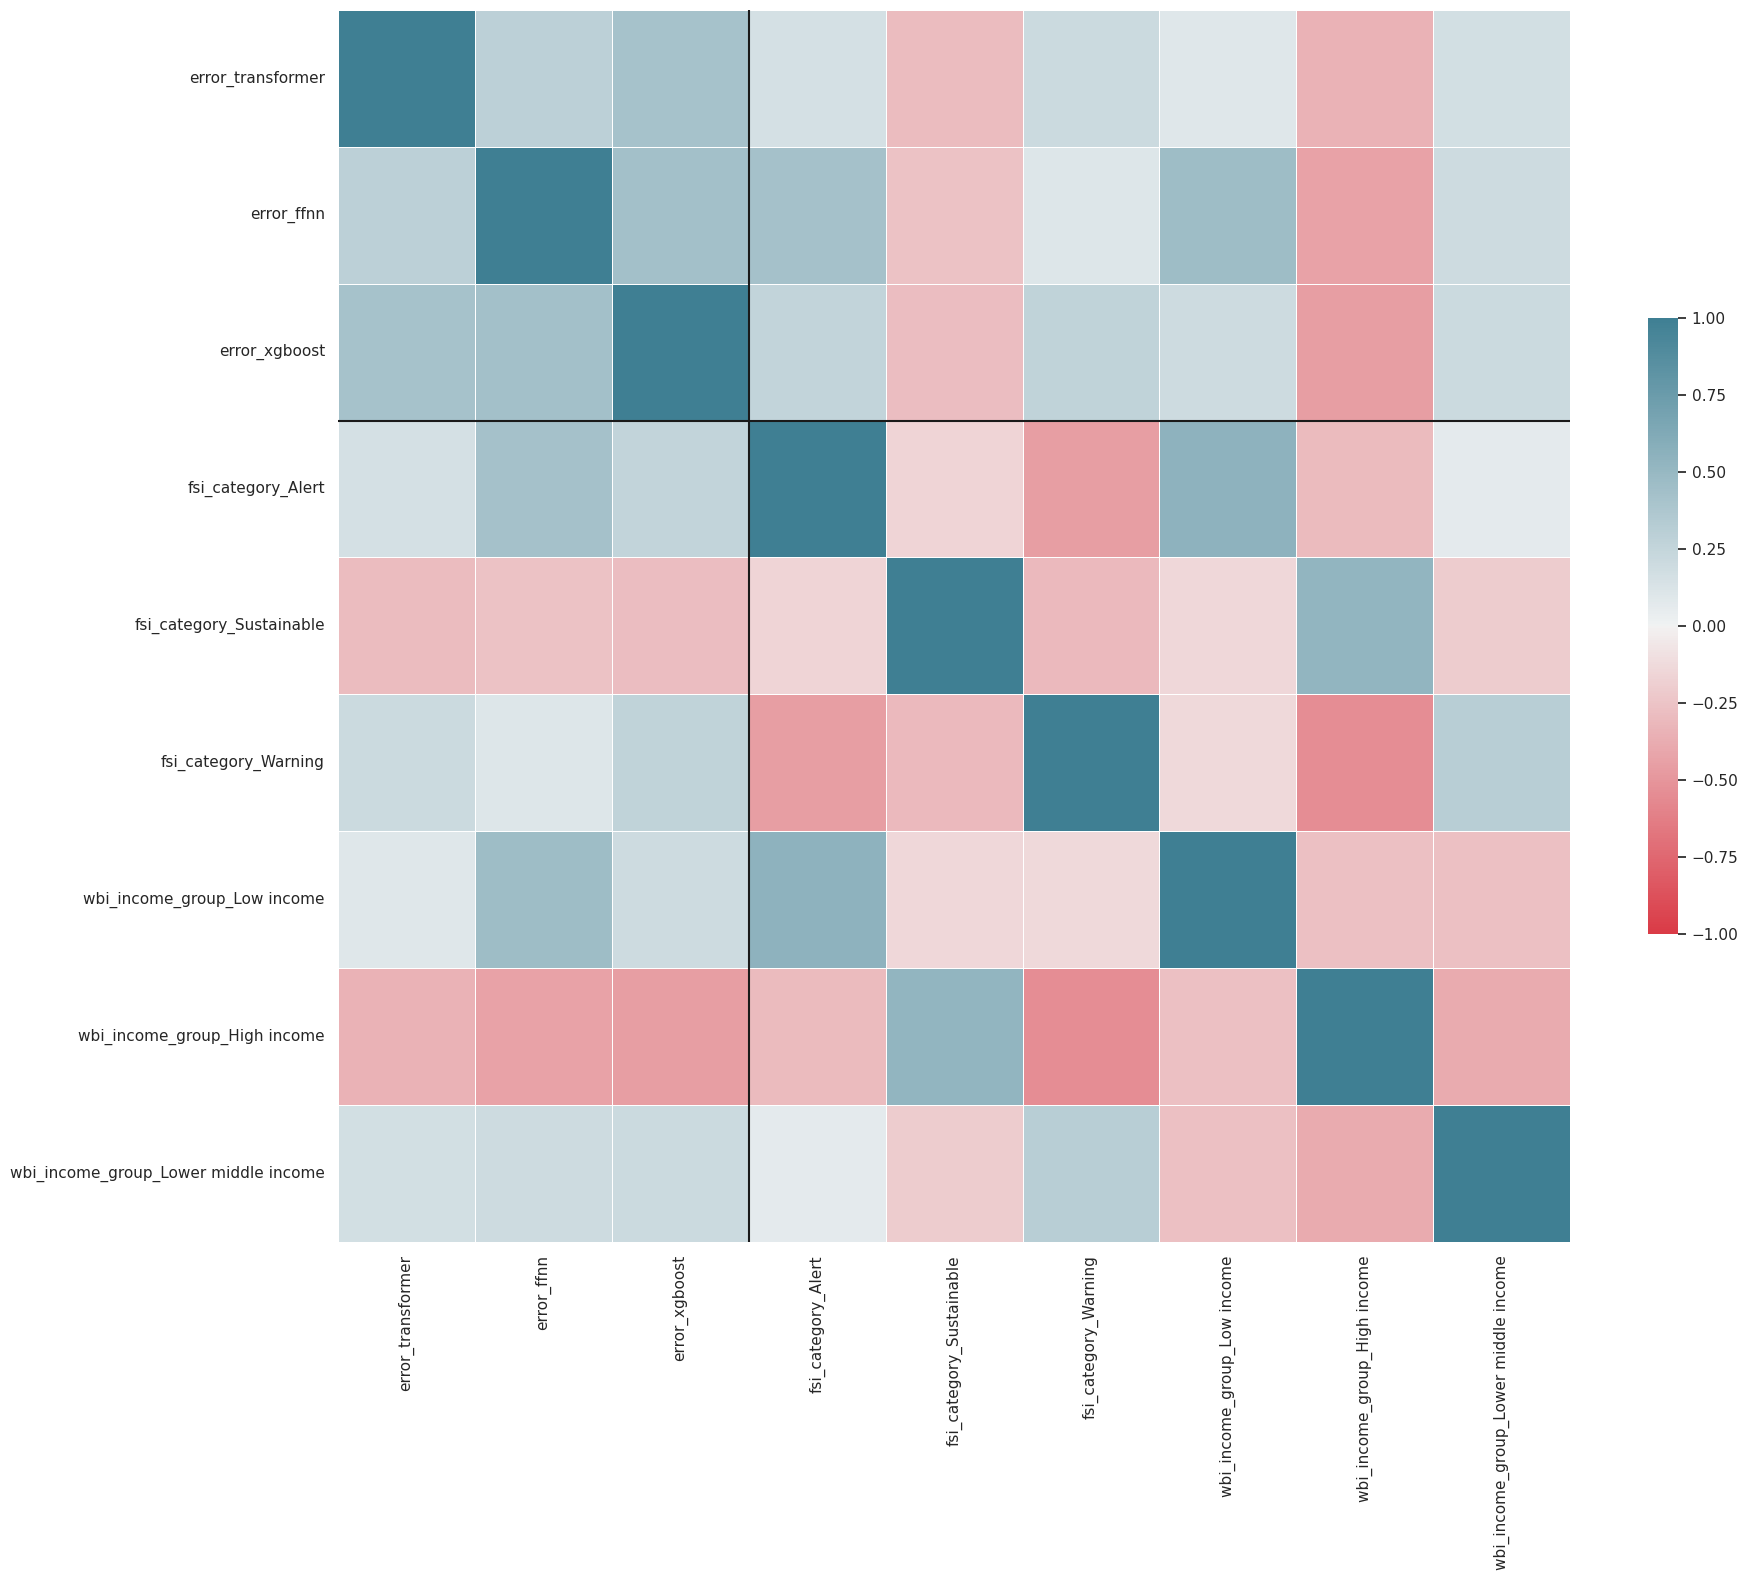

In [18]:
import matplotlib.pyplot as plt

#Simple heatmap to show some preliminary correlations between error and categorical variables
def corr_heatmap(df):
    # plot correlation heatmap based on code from:
    # https://medium.com/@nikolh92/helpful-visualisations-for-linear-regression-646a5648ad9d
    sns.set(style="white")
    corr = df.corr()
    mask = np.zeros_like(corr, dtype=bool)
    fig, ax = plt.subplots(figsize=(20, 16))
    cmap = sns.diverging_palette(10, 220, as_cmap=True)
    return sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, square=True,
                       linewidths=.5, annot=False, cbar_kws={"shrink": .5})

corr_heatmap(df_oh[['error_transformer','error_ffnn','error_xgboost'] + reduced_oh_cols])
_ = plt.axhline(y=3, c='k'); plt.axvline(x=3, c='k')

In [19]:
#MODEL CREATION CODE (FROM PROJECT NOTEBOOK)

# This will be used to make the (additional) indicator variables of which model a prediction corresponds to
df_oh['model_transformer'] = df_oh['error_transformer'].astype(str)*0+"transformer"
df_oh['model_ffnn'] = df_oh['error_ffnn'].astype(str)*0+"ffnn"
df_oh['model_xgboost'] = df_oh['error_xgboost'].astype(str)*0+"xgboost"

# The amount of error might change depending on if the prediction is positive or negative
# so this indicates if it was a postive or negative prediction
df_oh['prediction_transformer'] = df.y_true_transformer.astype(int)
df_oh['prediction_ffnn'] = df.y_pred_ffnn.astype(int)
df_oh['prediction_xgboost'] = df.y_true_xgboost.astype(int)

# This "stacks" all the predictions together on top of each other so they can all be analyzed together:
# (make sure you understand what this is actually doing and why!)
design_matrix = \
pd.concat([df_oh[['error_transformer', 'model_transformer', 'prediction_transformer']+reduced_oh_cols].rename(columns={'error_transformer':'error','model_transformer':'model','prediction_transformer':'predicts1'}),
           df_oh[['error_ffnn', 'model_ffnn', 'prediction_ffnn']+reduced_oh_cols].rename(columns={'error_ffnn':'error','model_ffnn':'model','prediction_ffnn':'predicts1'}),
           df_oh[['error_xgboost', 'model_xgboost', 'prediction_xgboost']+reduced_oh_cols].rename(columns={'error_xgboost':'error','model_xgboost':'model','prediction_xgboost':'predicts1'})],
          ignore_index=True)

# 1. design_matrix[reduced_oh_cols]*predicts1 offset changes to "baseline" when prediction is 1
design_matrix.predicts1 # is the intercept offset
for x in reduced_oh_cols:
    design_matrix[x+' X predicts1'] = design_matrix[x]*design_matrix['predicts1']

# 2. design_matrix[reduced_oh_cols]*`transformer`/`xgboost` additional offset changes to "baseline"
# when prediction is made by `transformer`/`xgboost` for any prediction (0 or 1)
design_matrix['transformer'] = (design_matrix['model']=="transformer").astype(int) # intercept offset
design_matrix['xgboost'] = (design_matrix['model']=="xgboost").astype(int) # intercept offset
for x in reduced_oh_cols:
    design_matrix[x+' X transformer'] = design_matrix[x]*design_matrix['transformer']
    design_matrix[x+' X xgboost'] = design_matrix[x]*design_matrix['xgboost']

# 3. design_matrix[reduced_oh_cols]*`transformer_predicts1`/`xgboost_predicts1` 
# additional offset changes to "baseline" for non `ffnn` 1 predictions      
design_matrix['transformer X predicts1'] = design_matrix['transformer']*design_matrix['predicts1']
design_matrix['xgboost X predicts1'] = design_matrix['xgboost']*design_matrix['predicts1']
for x in reduced_oh_cols:
    design_matrix[x+' X transformer X predicts1'] = design_matrix[x]*design_matrix['transformer X predicts1']
    design_matrix[x+' X xgboost X predicts1'] = design_matrix[x]*design_matrix['xgboost X predicts1']

# This is to address the "DataFrame is highly fragmented" warning that's being flagged below
design_matrix = design_matrix.copy()
y = design_matrix['error']
del design_matrix['error']
del design_matrix['model']

In [20]:
import statsmodels.api as sm

model_0_variables = design_matrix.columns.tolist()
model_0 = sm.OLS(y, sm.add_constant(design_matrix[model_0_variables]))
model_0.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  error   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     14.69
Date:                Wed, 06 Dec 2023   Prob (F-statistic):           6.27e-73
Time:                        21:45:43   Log-Likelihood:                 565.98
No. Observations:                1092   AIC:                            -1054.
Df Residuals:                    1053   BIC:                            -859.1
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
==================================================================================================================================
                                                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------
const                                                              0.3658      0.028     13.218      0.000       0.311       0.420
predicts1                                                          0.2632      0.107      2.463      0.014       0.054       0.473
fsi_category_Alert                                                 0.0461      0.044      1.048      0.295      -0.040       0.132
fsi_category_Sustainable                                          -0.0152      0.031     -0.495      0.621      -0.076       0.045
fsi_category_Warning                                               0.0253      0.030      0.839      0.401      -0.034       0.085
wbi_income_group_Low income                                        0.0821      0.151      0.543      0.587      -0.215       0.379
wbi_income_group_High income                                      -0.0259      0.032     -0.805      0.421      -0.089       0.037
wbi_income_group_Lower middle income                               0.0315      0.024      1.320      0.187      -0.015       0.078
fsi_category_Alert X predicts1                                    -0.0713      0.070     -1.013      0.311      -0.209       0.067
fsi_category_Sustainable X predicts1                               0.0451      0.068      0.666      0.506      -0.088       0.178
fsi_category_Warning X predicts1                                  -0.0938      0.065     -1.444      0.149      -0.221       0.034
wbi_income_group_Low income X predicts1                           -0.1300      0.213     -0.611      0.541      -0.548       0.288
wbi_income_group_High income X predicts1                           0.0606      0.043      1.407      0.160      -0.024       0.145
wbi_income_group_Lower middle income X predicts1                  -0.0892      0.151     -0.590      0.555      -0.386       0.207
transformer                                                        0.0224      0.041      0.546      0.585      -0.058       0.103
xgboost                                                           -0.0437      0.041     -1.076      0.282      -0.124       0.036
fsi_category_Alert X transformer                                   0.0789      0.060      1.306      0.192      -0.040       0.198
fsi_category_Alert X xgboost                                       0.2023      0.060      3.372      0.001       0.085       0.320
fsi_category_Sustainable X transformer                            -0.0745      0.044     -1.680      0.093      -0.162       0.013
fsi_category_Sustainable X xgboost                                -0.0053      0.044     -0.121      0.904      -0.092       0.081
fsi_category_Warning X transformer                                 0.0

In [21]:
#looking at lowest frequency values to remove from the model
design_matrix.sum().sort_values()

fsi_category_Sustainable X xgboost X predicts1                      1
fsi_category_Sustainable X transformer X predicts1                  2
fsi_category_Sustainable X predicts1                                3
wbi_income_group_High income X xgboost X predicts1                  8
wbi_income_group_High income X transformer X predicts1              8
wbi_income_group_Low income X xgboost X predicts1                   8
fsi_category_Alert X xgboost X predicts1                            9
fsi_category_Alert X transformer X predicts1                       11
wbi_income_group_Low income X transformer X predicts1              14
wbi_income_group_High income X predicts1                           16
wbi_income_group_Lower middle income X transformer X predicts1     19
wbi_income_group_Lower middle income X xgboost X predicts1         22
fsi_category_Warning X transformer X predicts1                     32
fsi_category_Warning X xgboost X predicts1                         34
fsi_category_Sustain

In [22]:
# we'll restrict ourselves to only examing categories that happen at least 15 or more times
#we tested different values but had a negative result (lower r^2 and higher multicolinearity)
design_matrix.loc[:,design_matrix.sum()>14].shape

(1092, 32)

In [23]:
model_1_variables = design_matrix.loc[:,design_matrix.sum()>14].columns.tolist()
model_1 = sm.OLS(y, sm.add_constant(design_matrix[model_1_variables]))
model_1.fit().summary().tables[-1]

Omnibus:,13.875,Durbin-Watson:,1.425
Prob(Omnibus):,0.001,Jarque-Bera (JB):,22.145
Skew:,0.049,Prob(JB):,1.55e-05
Kurtosis:,3.691,Cond. No.,101.


In [24]:
model_2_variables = model_1_variables.copy()

#(commented means still in the data)

#First pass: removing everything above 0.2:
#model_2_variables.remove('predicts1')
model_2_variables.remove('fsi_category_Alert')
model_2_variables.remove('fsi_category_Sustainable')
model_2_variables.remove('fsi_category_Warning')
model_2_variables.remove('wbi_income_group_Low income')
#model_2_variables.remove('wbi_income_group_High income')
#model_2_variables.remove('wbi_income_group_Lower middle income')
#model_2_variables.remove('fsi_category_Alert X predicts1')
#model_2_variables.remove('fsi_category_Warning X predicts1')
#model_2_variables.remove('wbi_income_group_Low income X predicts1')
#model_2_variables.remove('wbi_income_group_High income X predicts1')
#model_2_variables.remove('wbi_income_group_Lower middle income X predicts1')
model_2_variables.remove('transformer')
#model_2_variables.remove('xgboost')
#model_2_variables.remove('fsi_category_Alert X transformer')
#model_2_variables.remove('fsi_category_Alert X xgboost')
#model_2_variables.remove('fsi_category_Sustainable X transformer')
model_2_variables.remove('fsi_category_Sustainable X xgboost')
#model_2_variables.remove('fsi_category_Warning X transformer')
#model_2_variables.remove('fsi_category_Warning X xgboost')
model_2_variables.remove('wbi_income_group_Low income X transformer')
model_2_variables.remove('wbi_income_group_Low income X xgboost')
model_2_variables.remove('wbi_income_group_High income X transformer')
model_2_variables.remove('wbi_income_group_High income X xgboost')
model_2_variables.remove('wbi_income_group_Lower middle income X transformer')
model_2_variables.remove('wbi_income_group_Lower middle income X xgboost')
#model_2_variables.remove('transformer X predicts1')
#model_2_variables.remove('xgboost X predicts1')
#model_2_variables.remove('fsi_category_Warning X transformer X predicts1')
#model_2_variables.remove('fsi_category_Warning X xgboost X predicts1')
model_2_variables.remove('wbi_income_group_Lower middle income X transformer X predicts1')
model_2_variables.remove('wbi_income_group_Lower middle income X xgboost X predicts1')

model_2 = sm.OLS(y, sm.add_constant(design_matrix[model_2_variables]))
model_2.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  error   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                     30.27
Date:                Wed, 06 Dec 2023   Prob (F-statistic):           6.32e-83
Time:                        21:45:43   Log-Likelihood:                 557.97
No. Observations:                1092   AIC:                            -1078.
Df Residuals:                    1073   BIC:                            -983.0
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
const                                                0.3893      0.011     35.604      0.000       0.368       0.411
predicts1                                            0.5293      0.069      7.672      0.000       0.394       0.665
wbi_income_group_High income                        -0.0547      0.015     -3.749      0.000      -0.083      -0.026
wbi_income_group_Lower middle income                 0.0363      0.012      2.946      0.003       0.012       0.060
fsi_category_Alert X predicts1                      -0.2727      0.070     -3.902      0.000      -0.410      -0.136
fsi_category_Warning X predicts1                    -0.3191      0.077     -4.164      0.000      -0.470      -0.169
wbi_income_group_Low income X predicts1             -0.0911      0.041     -2.235      0.026      -0.171      -0.011
wbi_income_group_High income X predicts1             0.1140      0.059      1.926      0.054      -0.002       0.230
wbi_income_group_Lower middle income X predicts1    -0.1314      0.040     -3.279      0.001      -0.210      -0.053
xgboost                                             -0.0738      0.016     -4.514      0.000      -0.106      -0.042
fsi_category_Alert X transformer                     0.1189      0.021      5.620      0.000       0.077       0.160
fsi_category_Alert X xgboost                         0.2728      0.025     10.869      0.000       0.224       0.322
fsi_category_Sustainable X transformer              -0.0724      0.027     -2.681      0.007      -0.125      -0.019
fsi_category_Warning X transformer                   0.0761      0.016      4.789      0.000       0.045       0.107
fsi_category_Warning X xgboost                       0.2085      0.022      9.690      0.000       0.166       0.251
transformer X predicts1                             -0.2872      0.049     -5.867      0.000      -0.383      -0.191
xgboost X predicts1                                 -0.4125      0.052     -7.953      0.000      -0.514      -0.311
fsi_category_Warning X transformer X predicts1       0.1475      0.061      2.415      0.016       0.028       0.267
fsi_category_Warning X xgboost X predicts1           0.1245      0.063      1.978      0.048       0.001       0.248
==============================================================================
Omnibus:                       14.039   Durbin-Watson:                   1.426
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               22.231
Skew:                           0.060   Prob(JB):                     1.49e-05
Kurtosis:                       3.689   Cond. No.                         37.7
==============================================================================

Notes:
[1] Standard Errors assume 

In [25]:
model_3_variables = model_2_variables.copy()

#second pass -  removing everything above 0.05:
model_3_variables.remove('wbi_income_group_High income X predicts1')
model_3_variables.remove('fsi_category_Warning X xgboost X predicts1')
model_3_variables.remove('fsi_category_Warning X transformer X predicts1')


model_3 = sm.OLS(y, sm.add_constant(design_matrix[model_3_variables]))
model_3.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  error   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.321
Method:                 Least Squares   F-statistic:                     35.38
Date:                Wed, 06 Dec 2023   Prob (F-statistic):           5.05e-83
Time:                        21:45:43   Log-Likelihood:                 552.64
No. Observations:                1092   AIC:                            -1073.
Df Residuals:                    1076   BIC:                            -993.3
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
const                                                0.3861      0.011     35.713      0.000       0.365       0.407
predicts1                                            0.5204      0.044     11.866      0.000       0.434       0.606
wbi_income_group_High income                        -0.0487      0.014     -3.420      0.001      -0.077      -0.021
wbi_income_group_Lower middle income                 0.0370      0.012      3.002      0.003       0.013       0.061
fsi_category_Alert X predicts1                      -0.2588      0.052     -4.972      0.000      -0.361      -0.157
fsi_category_Warning X predicts1                    -0.2555      0.046     -5.594      0.000      -0.345      -0.166
wbi_income_group_Low income X predicts1             -0.1119      0.040     -2.776      0.006      -0.191      -0.033
wbi_income_group_Lower middle income X predicts1    -0.1657      0.039     -4.286      0.000      -0.242      -0.090
xgboost                                             -0.0746      0.016     -4.591      0.000      -0.106      -0.043
fsi_category_Alert X transformer                     0.1116      0.021      5.393      0.000       0.071       0.152
fsi_category_Alert X xgboost                         0.2697      0.025     10.834      0.000       0.221       0.319
fsi_category_Sustainable X transformer              -0.0732      0.027     -2.702      0.007      -0.126      -0.020
fsi_category_Warning X transformer                   0.0840      0.016      5.396      0.000       0.053       0.115
fsi_category_Warning X xgboost                       0.2145      0.021     10.227      0.000       0.173       0.256
transformer X predicts1                             -0.1981      0.031     -6.313      0.000      -0.260      -0.137
xgboost X predicts1                                 -0.3329      0.033    -10.203      0.000      -0.397      -0.269
==============================================================================
Omnibus:                       12.996   Durbin-Watson:                   1.437
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               19.993
Skew:                           0.061   Prob(JB):                     4.56e-05
Kurtosis:                       3.652   Cond. No.                         21.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
model_4_variables = model_3_variables.copy()

#third pass - removing everything no 0.000:
model_4_variables.remove('fsi_category_Sustainable X transformer')
model_4_variables.remove('wbi_income_group_Low income X predicts1')
model_4_variables.remove('wbi_income_group_Lower middle income')
model_4_variables.remove('wbi_income_group_Lower middle income X predicts1')

model_4 = sm.OLS(y, sm.add_constant(design_matrix[model_4_variables]))
model_4.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  error   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     44.58
Date:                Wed, 06 Dec 2023   Prob (F-statistic):           3.31e-80
Time:                        21:45:43   Log-Likelihood:                 538.14
No. Observations:                1092   AIC:                            -1052.
Df Residuals:                    1080   BIC:                            -992.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                  0.3972      0.010     39.682      0.000       0.378       0.417
predicts1                              0.4935      0.043     11.392      0.000       0.409       0.579
wbi_income_group_High income          -0.0697      0.013     -5.252      0.000      -0.096      -0.044
fsi_category_Alert X predicts1        -0.3652      0.042     -8.653      0.000      -0.448      -0.282
fsi_category_Warning X predicts1      -0.3505      0.038     -9.161      0.000      -0.426      -0.275
xgboost                               -0.0676      0.016     -4.218      0.000      -0.099      -0.036
fsi_category_Alert X transformer       0.1093      0.021      5.230      0.000       0.068       0.150
fsi_category_Alert X xgboost           0.2587      0.025     10.365      0.000       0.210       0.308
fsi_category_Warning X transformer     0.0906      0.016      5.771      0.000       0.060       0.121
fsi_category_Warning X xgboost         0.2140      0.021     10.237      0.000       0.173       0.255
transformer X predicts1               -0.1817      0.031     -5.926      0.000      -0.242      -0.122
xgboost X predicts1                   -0.3101      0.031     -9.961      0.000      -0.371      -0.249
==============================================================================
Omnibus:                       13.155   Durbin-Watson:                   1.431
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               20.379
Skew:                           0.059   Prob(JB):                     3.76e-05
Kurtosis:                       3.659   Cond. No.                         18.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
np.random.seed(110)
train_size = 800
data_indices = np.random.choice(design_matrix.index, size=design_matrix.shape[0], replace=False)
train_indices = data_indices[train_size:]
test_indices = data_indices[:train_size]

model_1_train_test_fit = sm.OLS(y[train_indices], sm.add_constant(design_matrix.iloc[train_indices][model_1_variables])).fit()
model_1_train_RMSE = ((y[train_indices] - model_1_train_test_fit.predict())**2).mean()**.5
model_1_test_RMSE = ((y[test_indices] - 
                      model_1_train_test_fit.predict(sm.add_constant(design_matrix.iloc[test_indices][model_1_variables]))
                     )**2).mean()**.5

model_2_train_test_fit = sm.OLS(y[train_indices], sm.add_constant(design_matrix.iloc[train_indices][model_2_variables])).fit()
model_2_train_RMSE = ((y[train_indices] - model_2_train_test_fit.predict())**2).mean()**.5
model_2_test_RMSE = ((y[test_indices] - 
                      model_2_train_test_fit.predict(sm.add_constant(design_matrix.iloc[test_indices][model_2_variables]))
                     )**2).mean()**.5

model_3_train_test_fit = sm.OLS(y[train_indices], sm.add_constant(design_matrix.iloc[train_indices][model_3_variables])).fit()
model_3_train_RMSE = ((y[train_indices] - model_3_train_test_fit.predict())**2).mean()**.5
model_3_test_RMSE = ((y[test_indices] - 
                      model_3_train_test_fit.predict(sm.add_constant(design_matrix.iloc[test_indices][model_3_variables]))
                     )**2).mean()**.5

model_4_train_test_fit = sm.OLS(y[train_indices], sm.add_constant(design_matrix.iloc[train_indices][model_4_variables])).fit()
model_4_train_RMSE = ((y[train_indices] - model_4_train_test_fit.predict())**2).mean()**.5
model_4_test_RMSE = ((y[test_indices] - 
                      model_4_train_test_fit.predict(sm.add_constant(design_matrix.iloc[test_indices][model_4_variables]))
                     )**2).mean()**.5

#graphs aren't loading correctly for me without this, might generate a new folder in directory
import plotly.io as pio
pio.renderers.default = 'iframe'

import plotly.express as px
px.bar(pd.DataFrame({'RMSE': [model_1_train_RMSE, model_2_train_RMSE, model_3_train_RMSE, model_4_train_RMSE] + 
                             [model_1_test_RMSE, model_2_test_RMSE, model_3_test_RMSE, model_4_test_RMSE],
                     'Score': ['Training']*4+['Testing']*4,
                     'Model': [1,2,3,4]+[1,2,3,4]}), 
       y='RMSE', x='Model', color='Score', barmode='group')

From train tests on models with progressive removal of features, we see each subsequent model trend further towards equality between the training and testing datasets. This is a good sign, as it indicates that each removal made the model more generalizable, with the final model being almost identical between datasets.